# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

Answer: To create a dataframe with just the customer_name and one column for each offer_id with a 1 or 0 if the customer responded to the offer - we need to merge the 2 dataframes provided. A left join on the offers dataset, would give all the entries of offers in the dataset and trasactions would be added to it. Once, this is done, pivot_table is used by specifying the index to be customer_name and convert the offer_id to separate columns for each offer_id and fill values of Nan with 0.

In [5]:
#your turn
# left merge
offer_merge_transac = df_offers.merge(df_transactions, how = 'left', left_on = 'offer_id', right_on = 'offer_id')
offer_merge_transac.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [6]:
# pivot table and reset index to customer_name
customer_offers = pd.pivot_table(offer_merge_transac, index=['customer_name'], values= 'n', columns=['offer_id'], fill_value=0)
customer_offers.reset_index(inplace=True)
customer_offers.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
print(customer_offers.shape)
customer_offers.head()

(100, 33)


offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Low values of SS represent better clusterings because samller the distance between the point and its centroid, the more denser or closely placed they are in the cluster.

In [8]:
# your turn
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


x_cols= np.matrix(customer_offers.iloc[:,2:33])
x_cols

matrix([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

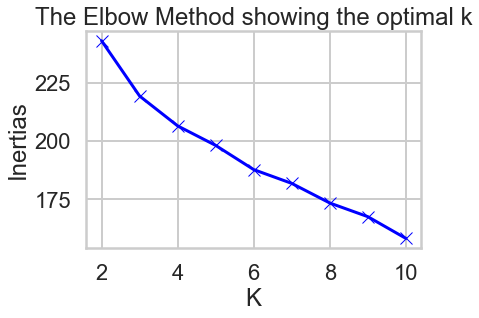

In [9]:
inertias = []
ks = range(2,11)
for i in ks:
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(x_cols)
    inertias.append(kmeans.inertia_)
# Plot the elbow
plt.plot(ks, inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertias')
plt.title('The Elbow Method showing the optimal k')
plt.show()



It is not very evident where the 'elbow' is in this scenario. It could be anywhere between 3 and 8. But, assuming that after 6, it kind of goes more flat, we can choose the best K as 6.

In [10]:
best_kmeans = KMeans(n_clusters=6, random_state=1)
best_kmeans.fit(x_cols)
clust_pred = best_kmeans.labels_

In [11]:
clusters, counts = np.unique(clust_pred, return_counts=True)
clusters = clusters+1
print(clusters, counts)

[1 2 3 4 5 6] [31 12 13 18 17  9]


Text(0.5, 1.0, 'Bar plot showing no. of points in each cluster')

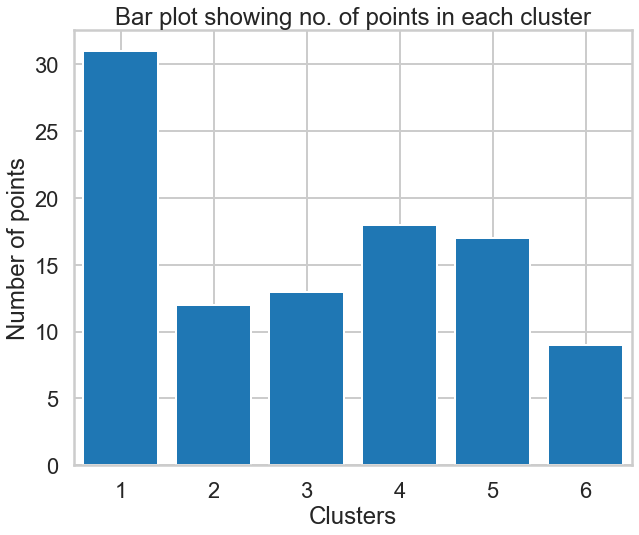

In [12]:
plt.figure(figsize=[10,8])
plt.bar(clusters, counts)
plt.xlabel('Clusters')
plt.xlim(0.5,6.5)
plt.ylabel('Number of points')
plt.title('Bar plot showing no. of points in each cluster')

Clearly, selecting a good value for K is not easy in the above example. The 'elbow' is not very evident as we do not see a clear flattening of the line. Maybe, more values for clusters will get us there but given the  size of the data set, this might lead to overfit too. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09467039888175721
For n_clusters = 3 The average silhouette_score is : 0.11916585417703293
For n_clusters = 4 The average silhouette_score is : 0.13572256736187485
For n_clusters = 5 The average silhouette_score is : 0.14373704530729803
For n_clusters = 6 The average silhouette_score is : 0.14307701634605718
For n_clusters = 7 The average silhouette_score is : 0.12466627806751378
For n_clusters = 8 The average silhouette_score is : 0.12777720637934897


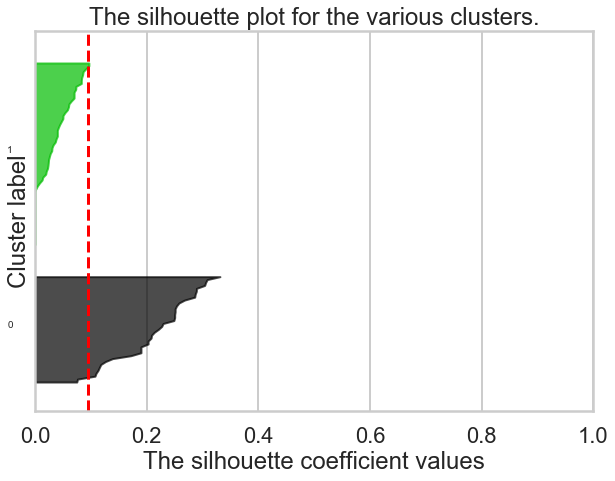

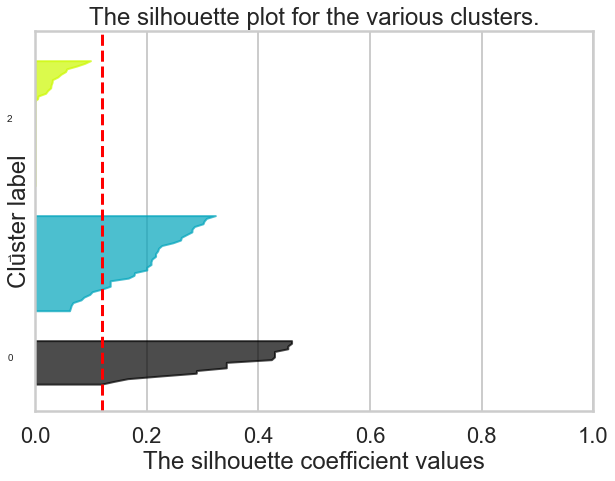

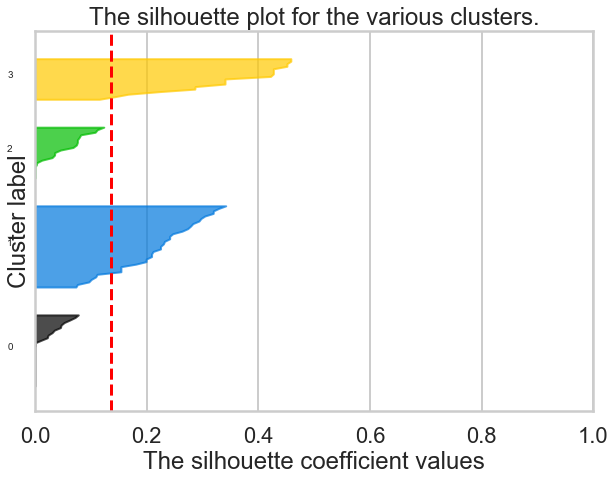

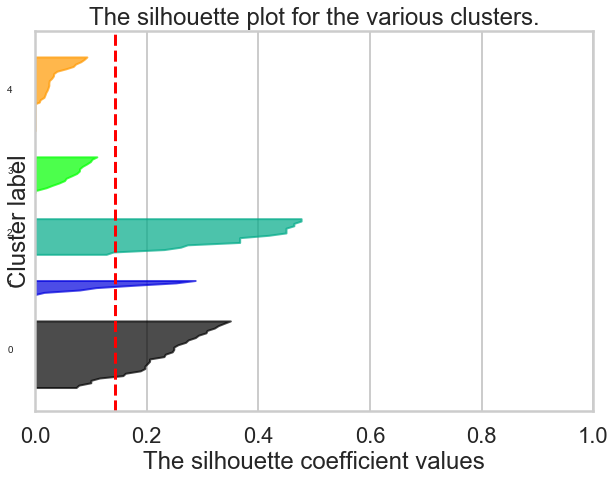

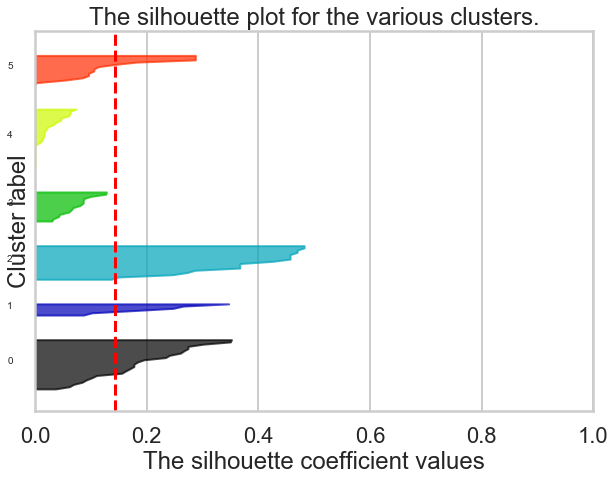

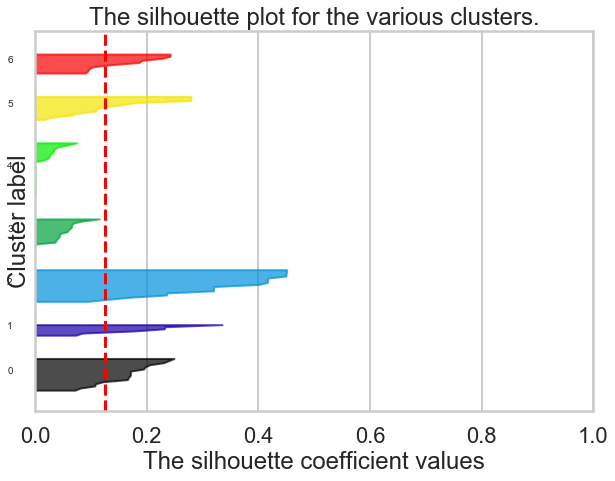

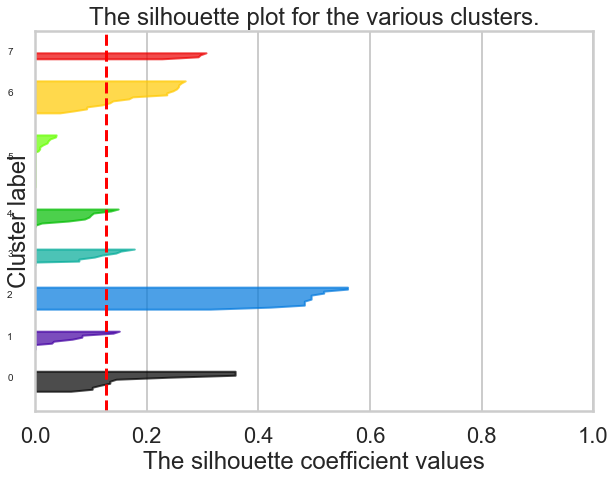

In [20]:
# Your turn.

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

ks = [2, 3, 4, 5, 6, 7, 8]


for k in ks:
    # Create a subplot with 1 row and 1 columns
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)
    ax.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clust = KMeans(n_clusters=k, random_state=10)
    clust_labels = clust.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    sil_avg = silhouette_score(x_cols, clust_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", sil_avg)

    # Compute the silhouette scores for each sample
    sample_sil_vals = silhouette_samples(x_cols, clust_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_clust_sil_vals = sample_sil_vals[clust_labels == i]
        ith_clust_sil_vals.sort()
        size_clust_i = ith_clust_sil_vals.shape[0]
        y_upper = y_lower + size_clust_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),x1=0, x2=ith_clust_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_clust_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        # The vertical line for average silhouette score of all the values
    ax.axvline(x=sil_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([ 0, 0.2, 0.4, 0.6, 0.8, 1])

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

   

Based on the silhouette plots and the scores, the best value for K is 5 as the score is the maximum when it is 5 which is 0.144. Though, the selection with the elbow method that I used was not too far off (K=6) with a score of 0.143, this was just chance - this method definitely eliminates that possibility. But, the score is still less than 0.25 which is the theshold for a substantial structure.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [21]:
#your turn

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(x_cols)

,customer_name,x,y,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,Adams,1.014908,0.157764,0,0,3,3,4,3
1,Allen,-0.313043,0.019268,1,1,2,4,3,1
2,Anderson,-0.451462,1.008114,1,2,1,2,2,4
3,Bailey,0.700551,0.006002,0,0,3,3,4,2
4,Baker,0.072574,-0.494352,0,1,0,4,1,0
...,...,...,...,...,...,...,...,...,...
95,Williams,-0.153799,-0.606370,1,1,0,4,1,1
96,Wilson,0.688087,0.013822,0,0,3,3,4,1
97,Wood,-0.398641,-0.339148,1,1,2,4,1,1
98,Wright,-0.523317,-0.436495,1,1,0,4,3,0


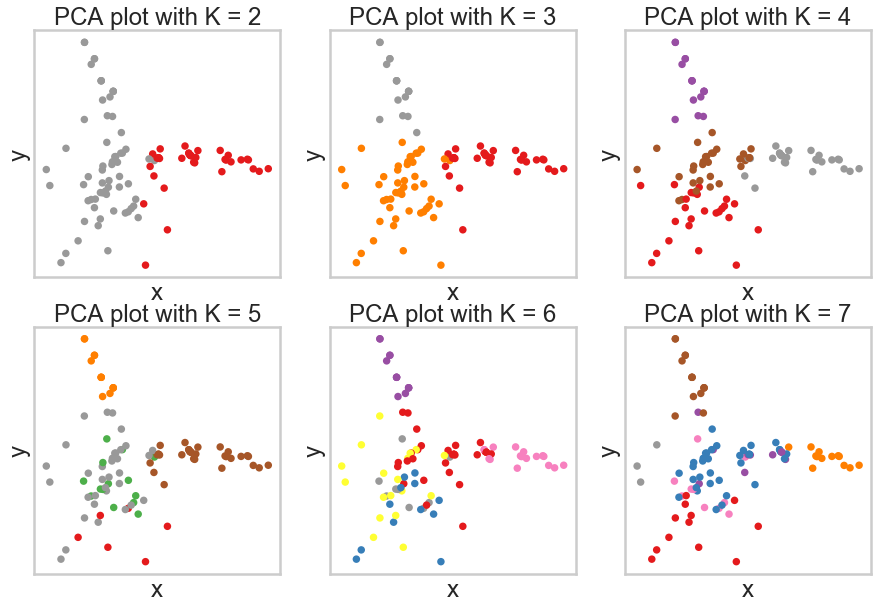

In [58]:
# KMeans using a range of K's
# iterating through the ks and calculating the cluster labels, creating a dataframe with those labels and the pcs from PCA,
# and then plotting a scatter plot for each k with the 2 principal components.

ks = [2,3,4,5,6,7]
fig = plt.figure(figsize=(15,10))
d = {'customer_name': customer_offers['customer_name'], 'x': pcs[:,0], 'y': pcs[:,1]}

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1)
    cluster_pred = kmeans.fit_predict(x_cols)
    d['cluster_'+str(k)] = cluster_pred
    df_pc = pd.DataFrame(d)
    ax = fig.add_subplot(2,3,k-1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.scatter(d['x'], d['y'], c=d['cluster_'+str(k)], s=30, cmap='Set1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('PCA plot with K = ' + str(k))
    
df_pc = pd.DataFrame(d)
df_pc

Looking at the visuals above, the best value for K seems to be either 3 or maybe 4. A single method has not been entirely successful in estimating the best K. Though the silhouette score helps a lot more to evaluate the K, this works only if the score is at least 0.25. In this case, where the max silhouette score is only 0.14, it is better to check with visualising the clusters with PCA, if there are more than 2 features. 

There are 9 varieties of wine in the data set from 9 different places. There are 4 types of min_qty offered. The clustering is not clear because all these features have an effect on the clusters formed and therefore the mixing of clusters.

In [23]:
df_offers['varietal'].unique()

array(['Malbec', 'Pinot Noir', 'Espumante', 'Champagne',
       'Cabernet Sauvignon', 'Prosecco', 'Chardonnay', 'Merlot',
       'Pinot Grigio'], dtype=object)

In [24]:
df_offers['origin'].unique()

array(['France', 'Oregon', 'New Zealand', 'Chile', 'Australia',
       'South Africa', 'California', 'Italy', 'Germany'], dtype=object)

In [25]:
df_offers['min_qty'].unique()

array([ 72, 144,   6,  12], dtype=int64)

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0.5, 1.0, 'Variance Explained vs. Components')

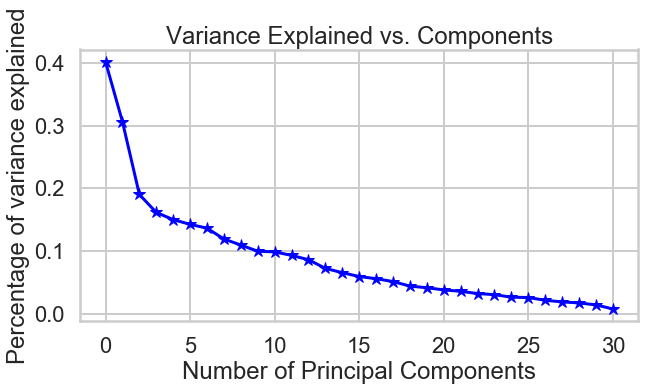

In [14]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pc_fit = pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(10,5))
plt.plot(pc_fit.explained_variance_, 'b*-')
plt.grid(True)
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. Components')


The elbow is near 5 and explains approx. 95% of the variance.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation

In [54]:
# Your turn
from sklearn.cluster import AffinityPropagation

# Inititate and get the labels with default damping values
cluster_ap= AffinityPropagation()
cluster_labels_ap = cluster_ap.fit_predict(x_cols)

Text(0.5, 1.0, 'PCA plot with Affinity Propagation')

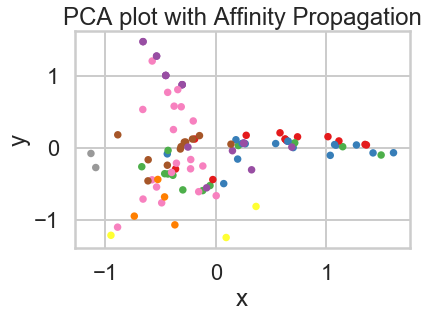

In [55]:
# create a dictionary with the labels and the 2 components of the PCA to make a scatter plot to visualise the 'cluster' formed.
ap = {'cluster': cluster_labels_ap, 'x': pcs[:,0], 'y': pcs[:,1]}
plt.scatter(ap['x'], ap['y'], c=ap['cluster'], s=30, cmap='Set1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA plot with Affinity Propagation')

For damping = 0.5 The average silhouette_score is : 0.1276758798641375
For damping = 0.6 The average silhouette_score is : 0.1276758798641375
For damping = 0.7 The average silhouette_score is : 0.1276758798641375
For damping = 0.8 The average silhouette_score is : 0.1276758798641375
For damping = 0.9 The average silhouette_score is : 0.09355308708044704


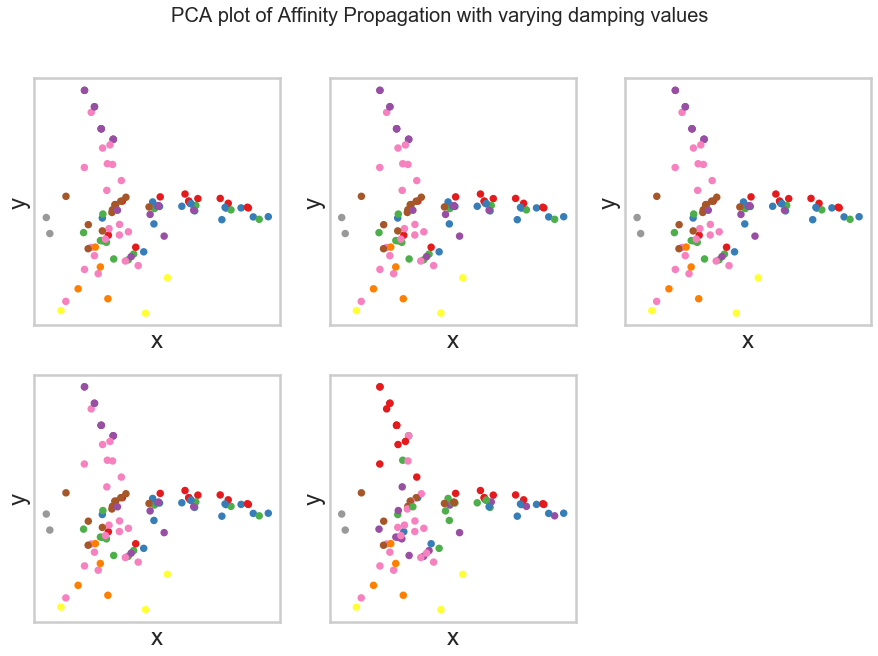

In [71]:
# Repeat for different values of 'damping'
ds = [0.5,0.6,0.7,0.8,0.9]
fig = plt.figure(figsize=(15,10))
ap = {'x': pcs[:,0], 'y': pcs[:,1]}

for i, d in enumerate(ds):
    cluster_ap= AffinityPropagation(damping=d)
    cluster_labels_ap = cluster_ap.fit_predict(x_cols)
    ap['cluster'] = cluster_labels_ap
    sil_avg_ap = silhouette_score(x_cols, cluster_labels_ap)
    print("For damping =", d,"The average silhouette_score is :", sil_avg_ap)
    ax = fig.add_subplot(2,3,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.scatter(ap['x'], ap['y'], c=ap['cluster'], s=30, cmap='Set1')
    plt.xlabel('x')
    plt.ylabel('y')
    fig.suptitle('PCA plot of Affinity Propagation with varying damping values', fontsize=20)

It does not look like the any of the values worked looking at the clusters visually. The silhouette scores are also less than 0.25 and even the KMeans model.

### Spectral Clustering

In [59]:
from sklearn.cluster import SpectralClustering

For n_clusters = 2 The average silhouette_score is : 0.08220549176093407
For n_clusters = 3 The average silhouette_score is : 0.11732767556688779
For n_clusters = 4 The average silhouette_score is : 0.08903955206147295
For n_clusters = 5 The average silhouette_score is : 0.1017922751616311
For n_clusters = 6 The average silhouette_score is : 0.10153494827748778
For n_clusters = 7 The average silhouette_score is : 0.08753628100543401


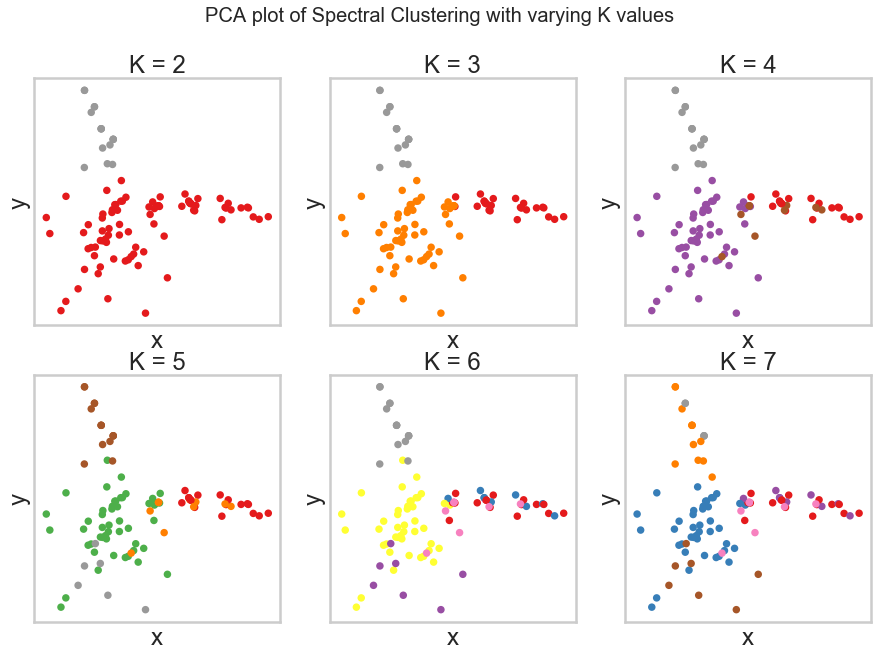

In [73]:
ks = [2,3,4,5,6,7]
fig = plt.figure(figsize=(15,10))
sc = {'x': pcs[:,0], 'y': pcs[:,1]}

for i, k in enumerate(ks):
    cluster_sc= SpectralClustering(n_clusters=k,assign_labels="discretize",random_state=1)
    cluster_labels_sc = cluster_sc.fit_predict(x_cols)
    sc['cluster'] = cluster_labels_sc
    sil_avg_sc = silhouette_score(x_cols, cluster_labels_sc)
    print("For n_clusters =", k,"The average silhouette_score is :", sil_avg_sc)
    ax = fig.add_subplot(2,3,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.scatter(sc['x'], sc['y'], c=sc['cluster'], s=30, cmap='Set1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('K = '+str(k))
    fig.suptitle('PCA plot of Spectral Clustering with varying K values', fontsize=20)

Visually, k=3 seems to be the better one. The silhouette scores also reflect the same thing though they are less than 0.25. k=4 does not look similar to the KMeans k=4 option we did in the previous question.

### Agglomerative Clustering

In [65]:
 from sklearn.cluster import AgglomerativeClustering

For n_clusters = 2 The average silhouette_score is : 0.0881375625640959
For n_clusters = 3 The average silhouette_score is : 0.11860367893918033
For n_clusters = 4 The average silhouette_score is : 0.1308745219672166
For n_clusters = 5 The average silhouette_score is : 0.141568488177945
For n_clusters = 6 The average silhouette_score is : 0.15126864802842463
For n_clusters = 7 The average silhouette_score is : 0.11993377695578616


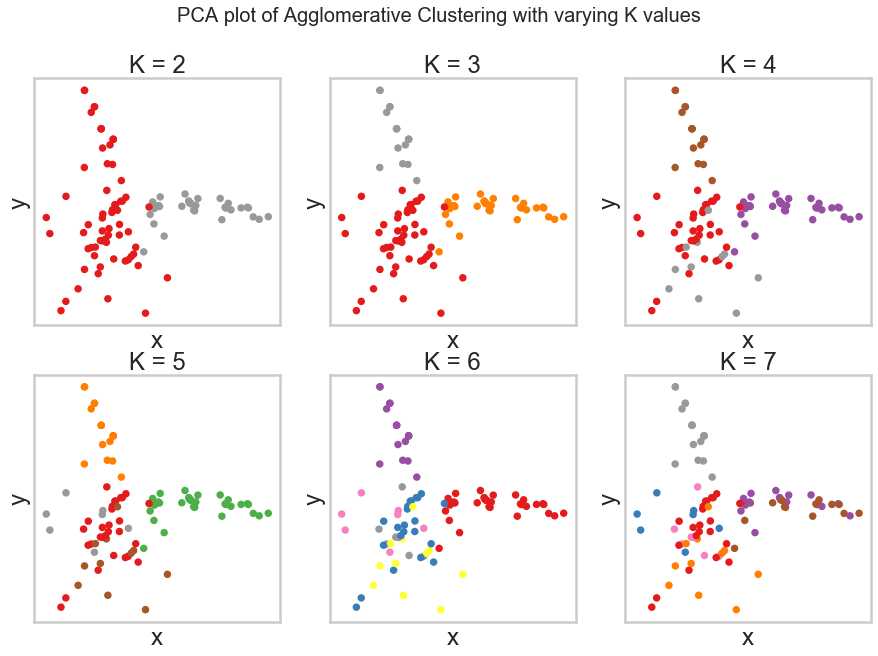

In [75]:
ks = [2,3,4,5,6,7]
fig = plt.figure(figsize=(15,10))
ac = {'x': pcs[:,0], 'y': pcs[:,1]}

for i, k in enumerate(ks):
    cluster_ac = AgglomerativeClustering(n_clusters=k)
    cluster_labels_ac = cluster_ac.fit_predict(x_cols)
    ac['cluster'] = cluster_labels_ac
    sil_avg_ac = silhouette_score(x_cols, cluster_labels_ac)
    print("For n_clusters =", k,"The average silhouette_score is :", sil_avg_ac)
    ax = fig.add_subplot(2,3,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.scatter(ac['x'], ac['y'], c=ac['cluster'], s=30, cmap='Set1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('K = '+str(k))
    fig.suptitle('PCA plot of Agglomerative Clustering with varying K values', fontsize=20)

Here again, a cluster of 3 looks more convincing visually but the silhouette scores are better than before with kmean, when k=6 or even k=5. But, since they are still less than 0.25, it doesn not give a concrete model.

### DBSCAN

In [76]:
from sklearn.cluster import DBSCAN

For eps = 1 The average silhouette_score is : 0.016223943555051933
For eps = 2 The average silhouette_score is : 0.24585173934674312


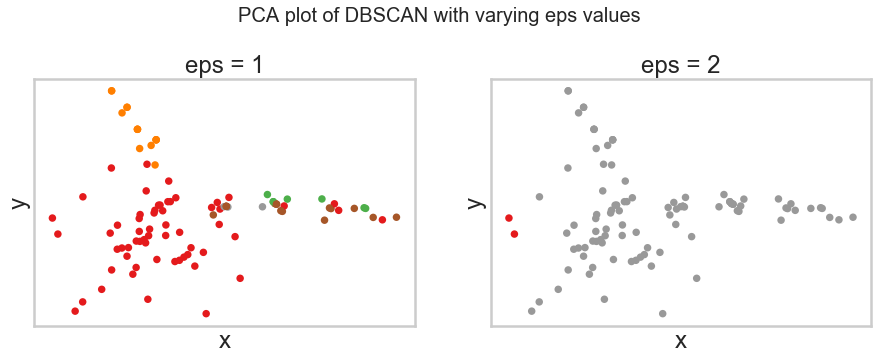

In [91]:
epss = [1,2]
fig = plt.figure(figsize=(15,10))
db = {'x': pcs[:,0], 'y': pcs[:,1]}

for i, e in enumerate(epss):
    cluster_db = DBSCAN(eps=e)
    cluster_labels_db = cluster_db.fit_predict(x_cols)
    db['cluster'] = cluster_labels_db
    sil_avg_db = silhouette_score(x_cols, cluster_labels_db)
    print("For eps =", e,"The average silhouette_score is :", sil_avg_db)
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.scatter(db['x'], db['y'], c=db['cluster'], s=30, cmap='Set1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('eps = '+str(e))
    fig.suptitle('PCA plot of DBSCAN with varying eps values', fontsize=20)

The eps values less than 1 do not show any cluster - just 1 big cluster. The eps= 2 shows a good silhouette score close to 0.25 that we have not got so far, but if visually, its almost like the eps values < 1 that have one cluster. Though eps = 1 shows some clustering, the silhouette scores are very low. Let us try changing the min_samples parameter to see if this brings any improvement.

For min_samples = 4 The average silhouette_score is : 0.043182176214119794
For min_samples = 5 The average silhouette_score is : 0.016223943555051933
For min_samples = 6 The average silhouette_score is : 0.023914692229594445
For min_samples = 7 The average silhouette_score is : -0.009344519664406399
For min_samples = 8 The average silhouette_score is : 0.013543329266474217
For min_samples = 9 The average silhouette_score is : 0.06366388233856018


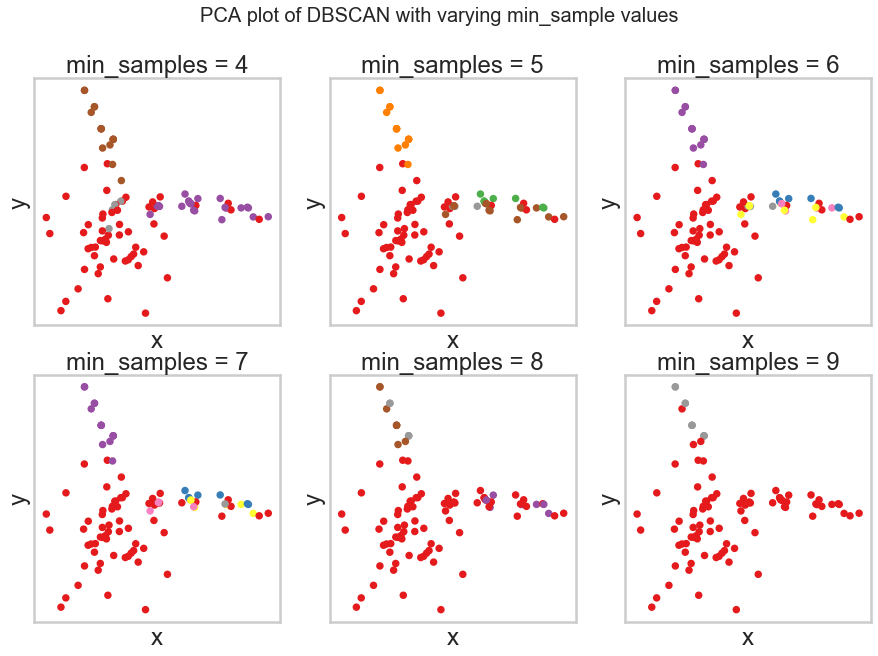

In [96]:
ms = [4,5,6,7,8,9]
fig = plt.figure(figsize=(15,10))
db = {'x': pcs[:,0], 'y': pcs[:,1]}

for i, m in enumerate(ms):
    cluster_db = DBSCAN(eps=1, min_samples=m)
    cluster_labels_db = cluster_db.fit_predict(x_cols)
    db['cluster'] = cluster_labels_db
    sil_avg_db = silhouette_score(x_cols, cluster_labels_db)
    print("For min_samples =", m,"The average silhouette_score is :", sil_avg_db)
    ax = fig.add_subplot(2,3,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.scatter(db['x'], db['y'], c=db['cluster'], s=30, cmap='Set1')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('min_samples = '+str(m))
    fig.suptitle('PCA plot of DBSCAN with varying min_sample values', fontsize=20)

None of the clustering algorithms seem to improve on the KMeans method. In terms of silhouette scores, agglomerative clustering had the highest score of 0.15 with k=6. Visually, k=3 or k=4 seem to make more sense of the clusters. DBSCAN actually shows that there is no clear cluster by showing just one cluster for a lot of eps values. 